# **LeMaterial/LeMat-Synth Dataset Analysis**

This notebook is a v0 data analysis of LeMaterial/LeMat-Synth-Papers dataset

## **Available Dataset Splits**
- **arxiv**: ArXiv research papers
- **chemrxiv**: ChemRxiv chemistry papers  
- **omg24**: OMG24 conference papers
- **sample_for_evaluation**: Evaluation samples

## **Load libraries**

In [ ]:
# Install required packages
!pip install pandas pyarrow matplotlib seaborn plotly python-dotenv requests -q
# install dotenv package
!pip install python-dotenv -q
# install tqdm package
!pip install tqdm -q
# installl wordcloud package
!pip install wordcloud -q

print("✅ Packages installed successfully!")

✅ Packages installed successfully!


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from collections import defaultdict
import re
import ast

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

import plotly.express as px

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [ ]:
# 1. Get (Colab secret) token or manually paste (for debug)
try:
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
except Exception as e:
    HF_TOKEN = ""  # Optionally paste your token here
print("HF_TOKEN is present:", bool(HF_TOKEN))

import os
os.environ['HF_TOKEN'] = HF_TOKEN

HF_TOKEN is present: True


In [ ]:
# 2. Clean existing files (avoid 0-byte problems)
for fname in ["arxiv.parquet", "chemrxiv.parquet", "omg24.parquet", "sample_for_evaluation.parquet"]:
    if os.path.exists(fname):
        os.remove(fname)

# 3. Download only the smaller datasets with curl and token
urls = {
    # Commenting out larger datasets to avoid memory issues
    # "arxiv.parquet": "https://huggingface.co/datasets/LeMaterial/LeMat-Synth/resolve/main/data/arxiv/arxiv.parquet",
    # "chemrxiv.parquet": "https://huggingface.co/datasets/LeMaterial/LeMat-Synth/resolve/main/data/chemrxiv/chemrxiv.parquet",
    # "omg24.parquet": "https://huggingface.co/datasets/LeMaterial/LeMat-Synth/resolve/main/data/omg24/omg24.parquet",
    "sample_for_evaluation.parquet": "https://huggingface.co/datasets/LeMaterial/LeMat-Synth-Papers/resolve/main/data/sample_for_evaluation-00000-of-00001.parquet"
}
for filename, url in urls.items():
    ret = os.system(f'curl -L -H "Authorization: Bearer $HF_TOKEN" "{url}" -o {filename}')
    print(f"Download {filename} exit code: {ret}")

# 4. Show file sizes and file types
!ls -lh *.parquet
!file *.parquet

Download sample_for_evaluation.parquet exit code: 0
-rw-r--r-- 1 root root 359M Aug  4 15:03 sample_for_evaluation.parquet
sample_for_evaluation.parquet: Apache Parquet


## **Data set exploration**

### **Understand the data**

Examine the columns, data types, and basic statistics.

In [ ]:
# Load the data
data = pd.read_parquet("sample_for_evaluation.parquet")
print(data.shape)

(300, 20)


In [ ]:
# View first 5 rows
data.head()

,id,title,authors,abstract,doi,published_date,updated_date,categories,license,pdf_url,views_count,read_count,citation_count,keywords,text_paper,text_si,source,pdf_extractor,images,structured_synthesis
0,1902.03049,Structure-dependent electrical properties of g...,"[Martini Leonardo , Chen Zongping , Mishra Nee...",Graphene nanoribbons (GNRs) are a novel and ...,10.1016/j.carbon.2019.01.071,2019,2019-02-11 00:00:00,Nanomaterials,http://arxiv.org/licenses/nonexclusive-distrib...,http://arxiv.org/pdf/1902.03049v1,NaN,NaN,NaN,None,# Structure-dependent electrical properties of...,,arxiv,other,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None
1,1610.04348,Synthetic Weyl points in generalized parameter...,"[Wang Qiang , Xiao Meng , Liu Hui , Wan Xianga...",Weyl fermions1 do not appear in nature as el...,None,2016,2016-10-17 00:00:00,Ceramics,http://arxiv.org/licenses/nonexclusive-distrib...,http://arxiv.org/pdf/1610.04348v1,NaN,NaN,NaN,None,## Synthetic Weyl points in generalized parame...,,arxiv,other,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None
2,2404.08872,Enhanced Hydrogen Evolution Activity of MOS$_2...,"[Sebastian Abhishek , R Pragna ]",Hydrogen evolution reaction (HER) has emerge...,None,2024,2024-04-16 00:00:00,Nanomaterials,http://creativecommons.org/licenses/by-nc-nd/4.0/,http://arxiv.org/pdf/2404.08872v1,NaN,NaN,NaN,None,# **Enhanced Hydrogen Evolution Activity of MO...,,arxiv,other,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None
3,2212.12506,A source of entangled photons based on a cavit...,"[Rota Michele B. , Krieger Tobias M. , Buching...",A quantum-light source that delivers photons...,10.1186/s43593-024-00072-8,2022,2024-07-26 00:00:00,Semiconductors,http://arxiv.org/licenses/nonexclusive-distrib...,http://arxiv.org/pdf/2212.12506v4,NaN,NaN,NaN,None,# A source of entangled photons based on a cav...,,arxiv,other,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None
4,2306.14755,Emergent Tetragonality in a Fundamentally Orth...,"[Singh Anisha G. , Bachmann Maja D. , Sanchez ...",Symmetry plays a key role in determining the...,10.1126/sciadv.adk3321,2023,2024-05-31 00:00:00,Semiconductors,http://arxiv.org/licenses/nonexclusive-distrib...,http://arxiv.org/pdf/2306.14755v2,NaN,NaN,NaN,None,# **Emergent Tetragonality in a Fundamentally ...,,arxiv,other,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None


In [ ]:
# View last 5 rows Hint: Use tail() method
data.tail()

,id,title,authors,abstract,doi,published_date,updated_date,categories,license,pdf_url,views_count,read_count,citation_count,keywords,text_paper,text_si,source,pdf_extractor,images,structured_synthesis
295,393b185d7ff4f8da5129d975d35ed67cc956ceff,Atomic layer deposition of vanadium oxide film...,"[Eloi Ros Costals, G. Masmitjà, Estefania Alma...",Transition metal oxides (TMOs) are promising m...,None,2021,2021,None,,https://pubs.rsc.org/en/content/articlepdf/202...,NaN,NaN,16.0,None,# Materials Advances\n\n## PAPER\n\nCite this:...,,omg24,None,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None
296,7fb868386d0f0a6ec80950dcd87cf09818fa5b00,Revisiting catalytic model reaction p-nitrophe...,"[Mao-lin Li, Guofang Chen]",The early reported pseudo-first-order reaction...,None,2013,2013,None,,https://pubs.rsc.org/en/content/articlepdf/201...,NaN,NaN,168.0,None,# Nanoscale\n\n# PAPER\n\n#### Cite this: Nano...,,omg24,None,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None
297,fd98f395b566b97783dac10d74f08a56f3d7aefa,A dual perspective on the microwave-assisted s...,"[Lucía Hortal, C. Pérez-Fernández, J. L. de la...",N/A,None,2020,2020,None,,https://www.nature.com/articles/s41598-020-791...,NaN,NaN,16.0,None,## **OPEN**\n\n![](_page_0_Picture_3.jpeg)\n\n...,,omg24,None,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None
298,c2e425ba21e6c3633f5093f627be50c7452008f5,Effects of Composition Variations on Mechanoch...,"[Bauyrzhan K. Abyshev, Sholpan Giniyatova, A. ...",The study examines the influence of variations...,None,2023,2023,None,,https://www.mdpi.com/2571-6131/6/4/147/pdf?ver...,NaN,NaN,0.0,None,# Article \n\n## Effects of Composition Variat...,,omg24,None,None,None
299,056254a9a39b91647b1973d7c9f30f96a37c9de5,The Characteristics of Cu2O Thin Films Deposit...,"[S. Lee, S. Yun, J. Lim]",We investigate the characteristics of Cu2O thi...,None,2013,2013,None,,https://onlinelibrary.wiley.com/doi/pdfdirect/...,NaN,NaN,24.0,None,,,omg24,None,None,None


In [ ]:
# View all the dataframe
display(data)

,id,title,authors,abstract,doi,published_date,updated_date,categories,license,pdf_url,views_count,read_count,citation_count,keywords,text_paper,text_si,source,pdf_extractor,images,structured_synthesis
0,1902.03049,Structure-dependent electrical properties of g...,"[Martini Leonardo , Chen Zongping , Mishra Nee...",Graphene nanoribbons (GNRs) are a novel and ...,10.1016/j.carbon.2019.01.071,2019,2019-02-11 00:00:00,Nanomaterials,http://arxiv.org/licenses/nonexclusive-distrib...,http://arxiv.org/pdf/1902.03049v1,NaN,NaN,NaN,None,# Structure-dependent electrical properties of...,,arxiv,other,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None
1,1610.04348,Synthetic Weyl points in generalized parameter...,"[Wang Qiang , Xiao Meng , Liu Hui , Wan Xianga...",Weyl fermions1 do not appear in nature as el...,None,2016,2016-10-17 00:00:00,Ceramics,http://arxiv.org/licenses/nonexclusive-distrib...,http://arxiv.org/pdf/1610.04348v1,NaN,NaN,NaN,None,## Synthetic Weyl points in generalized parame...,,arxiv,other,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None
2,2404.08872,Enhanced Hydrogen Evolution Activity of MOS$_2...,"[Sebastian Abhishek , R Pragna ]",Hydrogen evolution reaction (HER) has emerge...,None,2024,2024-04-16 00:00:00,Nanomaterials,http://creativecommons.org/licenses/by-nc-nd/4.0/,http://arxiv.org/pdf/2404.08872v1,NaN,NaN,NaN,None,# **Enhanced Hydrogen Evolution Activity of MO...,,arxiv,other,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None
3,2212.12506,A source of entangled photons based on a cavit...,"[Rota Michele B. , Krieger Tobias M. , Buching...",A quantum-light source that delivers photons...,10.1186/s43593-024-00072-8,2022,2024-07-26 00:00:00,Semiconductors,http://arxiv.org/licenses/nonexclusive-distrib...,http://arxiv.org/pdf/2212.12506v4,NaN,NaN,NaN,None,# A source of entangled photons based on a cav...,,arxiv,other,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None
4,2306.14755,Emergent Tetragonality in a Fundamentally Orth...,"[Singh Anisha G. , Bachmann Maja D. , Sanchez ...",Symmetry plays a key role in determining the...,10.1126/sciadv.adk3321,2023,2024-05-31 00:00:00,Semiconductors,http://arxiv.org/licenses/nonexclusive-distrib...,http://arxiv.org/pdf/2306.14755v2,NaN,NaN,NaN,None,# **Emergent Tetragonality in a Fundamentally ...,,arxiv,other,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None
5,cond-mat/0602418,Normal state electronic structure in the heavi...,"[Yang K. , Xie B. P. , Shen D. W. , Zhao J. F....",We explore the electronic structure in the h...,10.1103/PhysRevB.73.144507,2006,2007-05-23 00:00:00,Superconductors,None,http://arxiv.org/pdf/cond-mat/0602418v1,NaN,NaN,NaN,None,## Normal state electronic structure in the he...,,arxiv,other,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None
6,2012.05322,Deep Learning Segmentation of Complex Features...,"[Sadre Robbie , Ophus Colin , Butko Anstasiia ...",Phase contrast transmission electron microsc...,10.1017/S1431927621000167,2020,2021-09-01 00:00:00,Nanomaterials,http://creativecommons.org/licenses/by/4.0/,http://arxiv.org/pdf/2012.05322v1,NaN,NaN,NaN,None,# **Deep Learning Segmentation of Complex Feat...,,arxiv,other,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None
7,1909.02711,Flux Free Single Crystal Growth and Detailed P...,"[Sultana Rabia , Gurjar Ganesh , Gahtori Bhask...","Here, we report the crystal growth, physical...",10.1088/2053-1591/ab35b9,2019,2019-09-09 00:00:00,Topological Insulator,http://arxiv.org/licenses/nonexclusive-distrib...,http://arxiv.org/pdf/1909.02711v1,NaN,NaN,NaN,None,# Flux Free Single Crystal Growth and Detailed...,,arxiv,other,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None
8,1111.2910,Electronic structure and chemical bonding in T...,"[Magnuson M. , Wilhelmsson O. , Palmquist J. -...",The electronic structure of the nanolaminate...,10.1103/PhysRevB.74.195108,2011,2011-12-30 00:00:00,Nanomaterials,http://arxiv.org/licenses/nonexclusive-distrib...,http://arxiv.org/pdf/1111.2910v2,

In [ ]:
# Check the datatypes of each column.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    300 non-null    object 
 1   title                 300 non-null    object 
 2   authors               300 non-null    object 
 3   abstract              300 non-null    object 
 4   doi                   177 non-null    object 
 5   published_date        300 non-null    object 
 6   updated_date          300 non-null    object 
 7   categories            200 non-null    object 
 8   license               280 non-null    object 
 9   pdf_url               300 non-null    object 
 10  views_count           100 non-null    float64
 11  read_count            100 non-null    float64
 12  citation_count        200 non-null    float64
 13  keywords              92 non-null     object 
 14  text_paper            300 non-null    object 
 15  text_si               3

In [ ]:
# Numerical statistics
data.describe()

,views_count,read_count,citation_count
count,100.000000,100.00000,200.000000
mean,1601.120000,663.93000,8.420000
std,1200.406676,943.18062,20.429154
min,242.000000,91.00000,0.000000
25%,648.000000,303.75000,0.000000
50%,1084.000000,479.00000,1.000000
75%,2610.250000,740.75000,6.250000
max,5769.000000,8647.00000,168.000000


### **Handle missing values**

Identify and address any missing values in the DataFrame.

In [ ]:
missing_percentages = data.isnull().sum()
print("Percentage of missing values per column:")
print(missing_percentages)
if 'images' in data.columns:
   data = data.drop('images', axis=1)
   print("\n'images' column dropped.")

# Fill remaining missing values with "N/A"
data = data.fillna("N/A")
print("\nRemaining missing values filled with 'N/A'.")

# Verify that there are no more missing values
print("\nMissing values after handling:")
print(data.isnull().sum().sum())

Percentage of missing values per column:
id                        0
title                     0
authors                   0
abstract                  0
doi                     123
published_date            0
updated_date              0
categories              100
license                  20
pdf_url                   0
views_count             200
read_count              200
citation_count          100
keywords                208
text_paper                0
text_si                   0
source                    0
pdf_extractor           100
images                   48
structured_synthesis    300
dtype: int64

'images' column dropped.

Remaining missing values filled with 'N/A'.

Missing values after handling:
0


## **Data Visualisation**

 Create visualizations to understand the distribution and relationships within the data.

### **Summary statistics of all categorical variables**

In [ ]:
# Explore basic summary statistics of categorical variables.
data.describe(include=['object'])

,id,title,authors,abstract,doi,published_date,updated_date,categories,license,pdf_url,views_count,read_count,citation_count,keywords,text_paper,text_si,source,pdf_extractor,structured_synthesis
count,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300
unique,298,298,300,262,176,125,199,118,8,298,95,95,39,93,289,70,3,3,1
top,64348509a41dec1a56d8902b,Electrically Conductive [Fe4S4]-based Organome...,"[S. Lee, S. Yun, J. Lim]",N/A,N/A,2023,2023,N/A,,https://chemrxiv.org/engage/api-gateway/chemrx...,N/A,N/A,N/A,N/A,,,arxiv,other,N/A
freq,2,2,1,37,123,30,24,101,100,2,200,200,100,208,10,231,100,100,300


### **Distribution of publications by date**

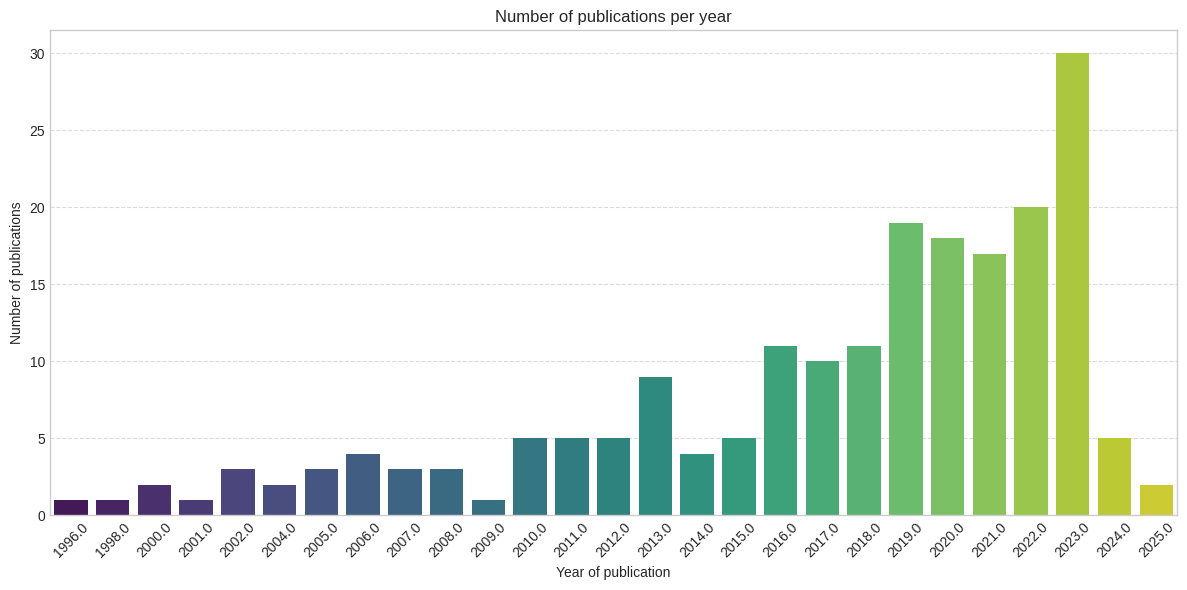

In [ ]:
data['published_date'] = pd.to_datetime(data['published_date'], errors='coerce')

plt.figure(figsize=(12, 6))
data['published_year'] = data['published_date'].dt.year
sns.countplot(data=data, x='published_year', palette='viridis')
plt.title('Number of publications per year')
plt.xlabel('Year of publication')
plt.ylabel('Number of publications')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Observations**

The dataset spans publication dates from 1996 to 2025, with a median publication year of 2019, indicating a concentration of more recent papers. The year 2023 has the highest number of publications in the dataset.

### **Distribution of source**

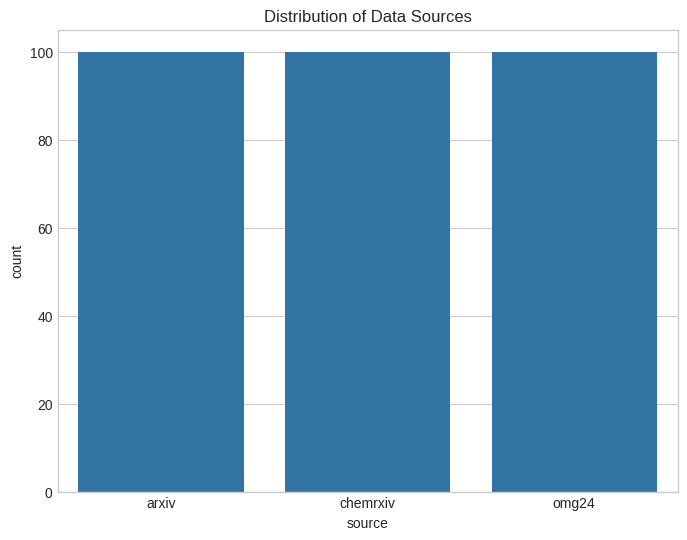

In [ ]:
# Create a countplot of the 'source' column
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='source')
plt.title("Distribution of Data Sources")
plt.show()

In [ ]:
data['source'].value_counts()

,count
source,
arxiv,100
chemrxiv,100
omg24,100


**Observations:**

 The dataset consists of 300 research papers from three sources: 'arxiv', 'chemrxiv', and 'omg24', with 100 papers from each.


### **Distribution of views, reads, citations**

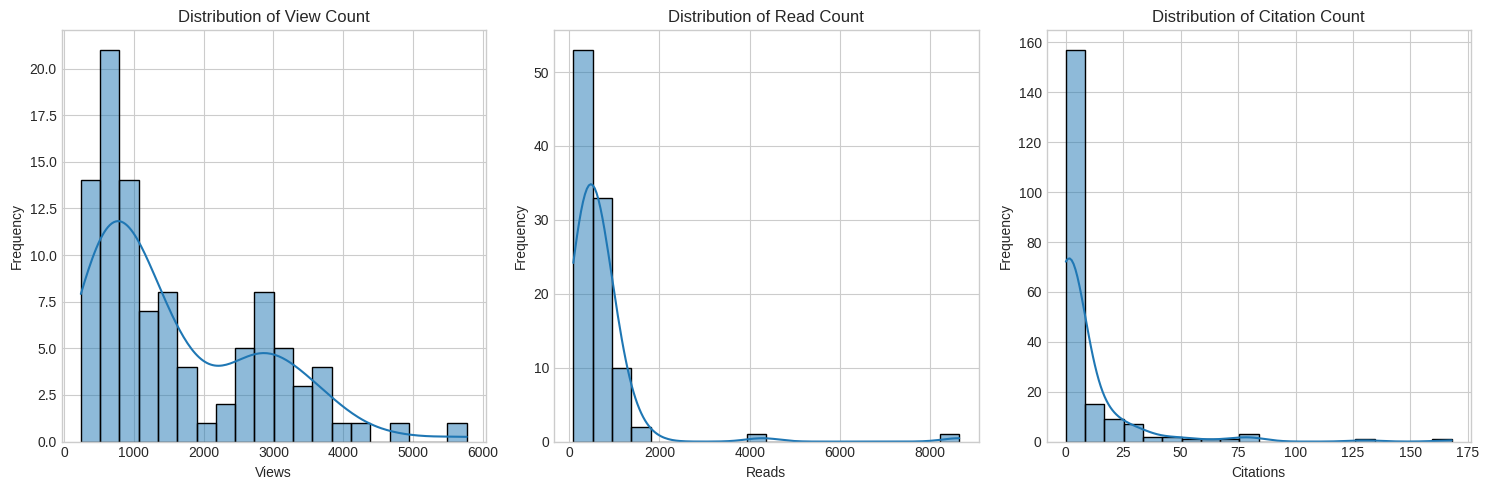

In [ ]:
# Convert relevant columns to numeric, coercing errors
data['views_count'] = pd.to_numeric(data['views_count'], errors='coerce')
data['read_count'] = pd.to_numeric(data['read_count'], errors='coerce')
data['citation_count'] = pd.to_numeric(data['citation_count'], errors='coerce')

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(data['views_count'].dropna(), kde=True, bins=20)
plt.title('Distribution of View Count')
plt.xlabel('Views')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(data['read_count'].dropna(), kde=True, bins=20)
plt.title('Distribution of Read Count')
plt.xlabel('Reads')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(data['citation_count'].dropna(), kde=True, bins=20)
plt.title('Distribution of Citation Count')
plt.xlabel('Citations')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Observations:**

The distributions of views, reads and citations show strongly right-skewed trends, indicating the presence of a few high-performing publications within a majority of low-impact ones.

- Views: spread distribution with a mode around 500–1000 views; a few publications exceed 5000 views.

- Reads: more concentrated distribution, with the majority of articles below 1,000 reads; rare extreme cases up to 8,000.

- Citations: highly unbalanced distribution; the majority of publications have fewer than 10 citations, with very few exceeding 50.

This asymmetry reflects a concentration of visibility and scientific impact on a small number of publications.

### **Frenquency of categories**

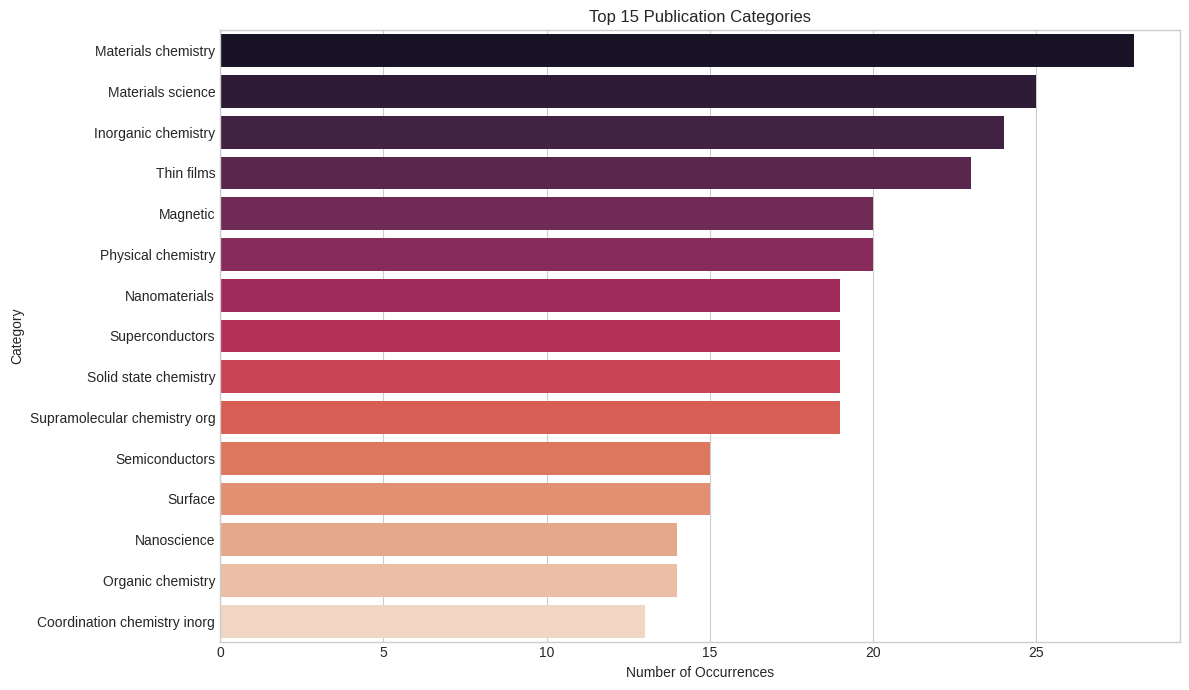

In [ ]:
# Function to clean and flatten category strings
def clean_categories(categories_list):
    cleaned = []
    if isinstance(categories_list, str):
        try:
            # Attempt to safely evaluate the string as a Python literal (like a list)
            categories_list = ast.literal_eval(categories_list)
        except (ValueError, SyntaxError):
            # If evaluation fails, treat the string as a comma/semicolon separated list
            categories_list = [categories_list] # Put the string in a list to process below

    if isinstance(categories_list, list):
        for category in categories_list:
            if isinstance(category, str): # Ensure the element is a string
                # Clean special characters and unwanted spaces
                # Split by comma and then by semicolon, strip whitespace, handle potential empty strings
                for part in category.split(','):
                    for sub_part in part.split(';'):
                         cleaned_category = re.sub(r'[^a-zA-Z0-9\s]', '', sub_part).strip()
                         cleaned_category = cleaned_category.capitalize()
                         # Eliminate generic or irrelevant categories (including "Other" and "Na")
                         if cleaned_category and cleaned_category.lower() not in ['material', 'science', 'others', 'n/a', 'other', 'na']:
                             cleaned.append(cleaned_category)
    return cleaned

all_cleaned_categories = [category for sublist in data['categories'].apply(clean_categories) for category in sublist]
category_counts = Counter(all_cleaned_categories)

# Convert to DataFrame for better visualization with seaborn
df_categories = pd.DataFrame(category_counts.most_common(15), columns=['Category', 'Count'])

plt.figure(figsize=(12, 7))
sns.barplot(data=df_categories, x='Count', y='Category', palette='rocket')
plt.title('Top 15 Publication Categories')
plt.xlabel('Number of Occurrences')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

**Observations:**

Publications are mainly concentrated in the fields of materials chemistry, materials science and inorganic chemistry, reflecting a strong focus on research into functional materials. Other dominant categories such as thin films, magnetic and nanomaterials indicate a focus on materials physics at the nanometric scale. This distribution highlights a marked specialisation at the interface between chemistry, physics and nanosciences.

### **Top of keywords**

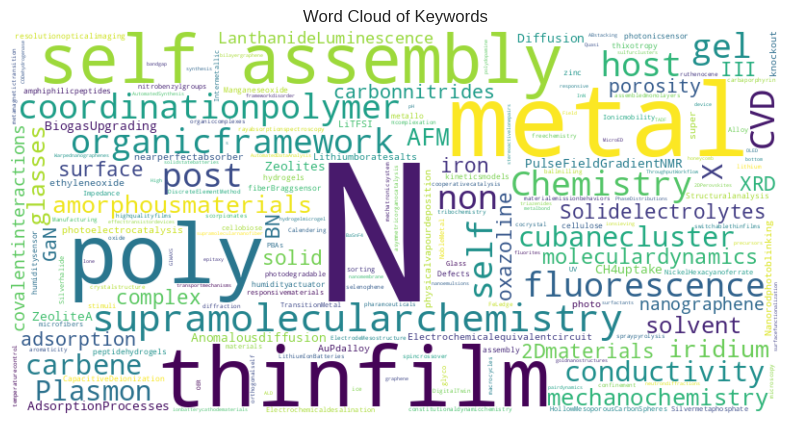

In [ ]:
# Function to clean and format keywords
def clean_keywords(keyword_entry):
    cleaned_keywords = []
    if isinstance(keyword_entry, str):
        # Split by semicolon first to get individual keyword strings
        keyword_strings = keyword_entry.split(';')
        for kw_str in keyword_strings:
            # Remove apostrophes and brackets, then strip whitespace
            cleaned_kw = kw_str.replace("'", "").replace("[", "").replace("]", "").strip()
            # Join letters that might have been separated by apostrophes in the original data
            # This assumes the apostrophes were just separators, and the remaining characters form the word
            cleaned_kw = "".join(cleaned_kw.split()) # Remove any remaining spaces within the word

            if cleaned_kw:
                cleaned_keywords.append(cleaned_kw)
    return cleaned_keywords

# Apply the cleaning function to the 'keywords' column and flatten the list of lists
# Ensure to handle NaN values by converting to string and checking
all_cleaned_keywords = [keyword for sublist in data['keywords'].astype(str).apply(clean_keywords) for keyword in sublist]

# Join all cleaned keywords into a single string for the word cloud
text = ' '.join(all_cleaned_keywords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Keywords')
plt.show()

**Observations:**

The keyword map highlights themes that are strongly correlated with the main publication categories identified above. Terms such as ‘thin film’, ‘metal’, ‘self assembly’, ‘coordination polymer’, “MOF” and ‘supramolecular chemistry’ appear in large font, indicating their high frequency. These keywords confirm the predominance of topics in materials chemistry, inorganic chemistry, nanomaterials and supramolecular chemistry. The recurrence of terms such as ‘porosity’, ‘framework’, ‘host’, “luminescence” and ‘solid electrolytes’ reinforces the idea of a strong interest in functional materials, particularly porous or hybrid materials, for optoelectronic, catalytic or energy applications.

In [ ]:
# Count the frequency of each keyword
keyword_counts = Counter(all_cleaned_keywords)

# Convert to DataFrame for better display
# Let's display the top 20 keywords for now
top_n_keywords = 20
df_top_keywords = pd.DataFrame(keyword_counts.most_common(top_n_keywords), columns=['Keyword', 'Count'])

print(f"Top {top_n_keywords} Keywords for the entire sample:")
display(df_top_keywords)

Top 20 Keywords for the entire sample:


,Keyword,Count
0,N/A,208
1,self-assembly,5
2,thinfilms,4
3,Chemistry,3
4,supramolecularchemistry,3
5,CVD,3
6,cubanecluster,2
7,conductivity,2
8,coordinationpolymer,2
9,carbene,2


## **Relationship between views, reads and citations**

In [ ]:
# Let's ensure these columns are numeric, coercing errors to NaN
# and then fill NaNs if necessary (e.g., with 0 or the mean)
for col in ['views_count', 'read_count', 'citation_count']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].fillna(0)

# Calculate aggregate statistics for the entire dataset
# This is often done using .describe() or .agg()
aggregated_stats = data[['views_count', 'read_count', 'citation_count']].agg(['sum', 'mean', 'median', 'min', 'max', 'std'])

print("Aggregated Statistics for Views, Reads, and Citations:")
display(aggregated_stats)

Aggregated Statistics for Views, Reads, and Citations:


,views_count,read_count,citation_count
sum,160112.000000,66393.000000,1684.000000
mean,533.706667,221.310000,5.613333
median,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.000000
max,5769.000000,8647.000000,168.000000
std,1024.062221,626.761726,17.134052


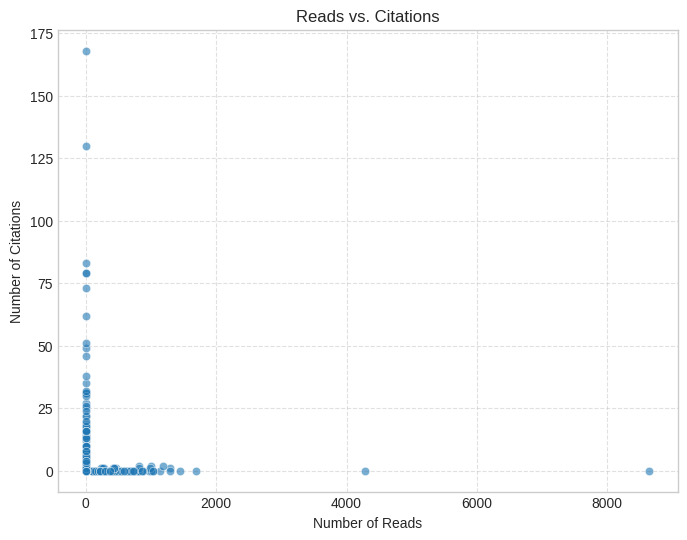

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='read_count', y='citation_count', alpha=0.6)
plt.title('Reads vs. Citations')
plt.xlabel('Number of Reads')
plt.ylabel('Number of Citations')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

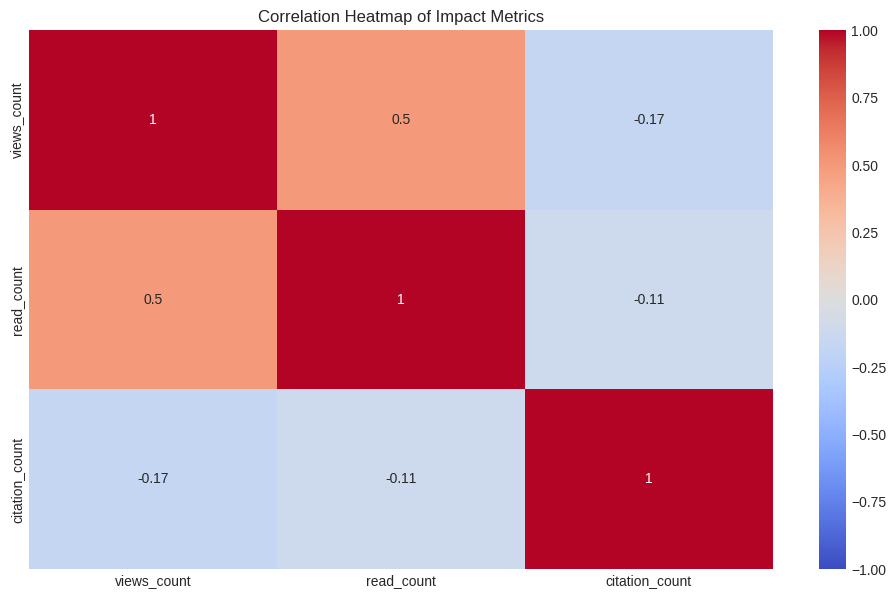

In [ ]:
# Create heatmap with the citation count, read count and views count
plt.figure(figsize = (12, 7))

sns.heatmap(data[['views_count', 'read_count', 'citation_count']].corr(), annot = True, vmin = -1, vmax = 1, cmap='coolwarm')

plt.title('Correlation Heatmap of Impact Metrics')

plt.show()

## **Advanced data exploration**

Perform a deeper dive into the dataset by exploring relationships between columns.

### **Categories**

In [ ]:
# Combine categories from all sources with category data
all_categories = []
# Using the main 'data' DataFrame and iterating through rows
if 'data' in globals():
    for index, row in data.iterrows():
        # Use the cleaned categories if available, otherwise clean them here
        categories = row.get('cleaned_categories')
        if categories is None or not isinstance(categories, list):
            def clean_single_category_entry(categories_list):
                cleaned = []
                if isinstance(categories_list, str):
                    try:
                        categories_list = ast.literal_eval(categories_list)
                    except (ValueError, SyntaxError):
                        categories_list = [categories_list]

                if isinstance(categories_list, list):
                    for category in categories_list:
                        if isinstance(category, str):
                            for part in category.split(','):
                                for sub_part in part.split(';'):
                                     cleaned_category = sub_part.strip()
                                     if cleaned_category:
                                         cleaned.append(cleaned_category)
                return cleaned
            categories = clean_single_category_entry(row['categories'])


        # Filter out 'N/A', 'Other', 'Others', 'NA' (case-insensitive)
        filtered_categories = [cat for cat in categories if isinstance(cat, str) and cat.lower() not in ['n/a', 'other', 'others', 'na']]
        all_categories.extend(filtered_categories)

if all_categories:
    # Count the frequency of each category
    category_counts = Counter(all_categories)
    category_df = pd.DataFrame(category_counts.items(), columns=['Category', 'Count'])

    # Create a treemap
    fig = px.treemap(category_df, path=['Category'], values='Count',
                     title='Treemap of Categories Across All Sources')
    fig.show()
else:
    print("No category data available to create a treemap after filtering.")

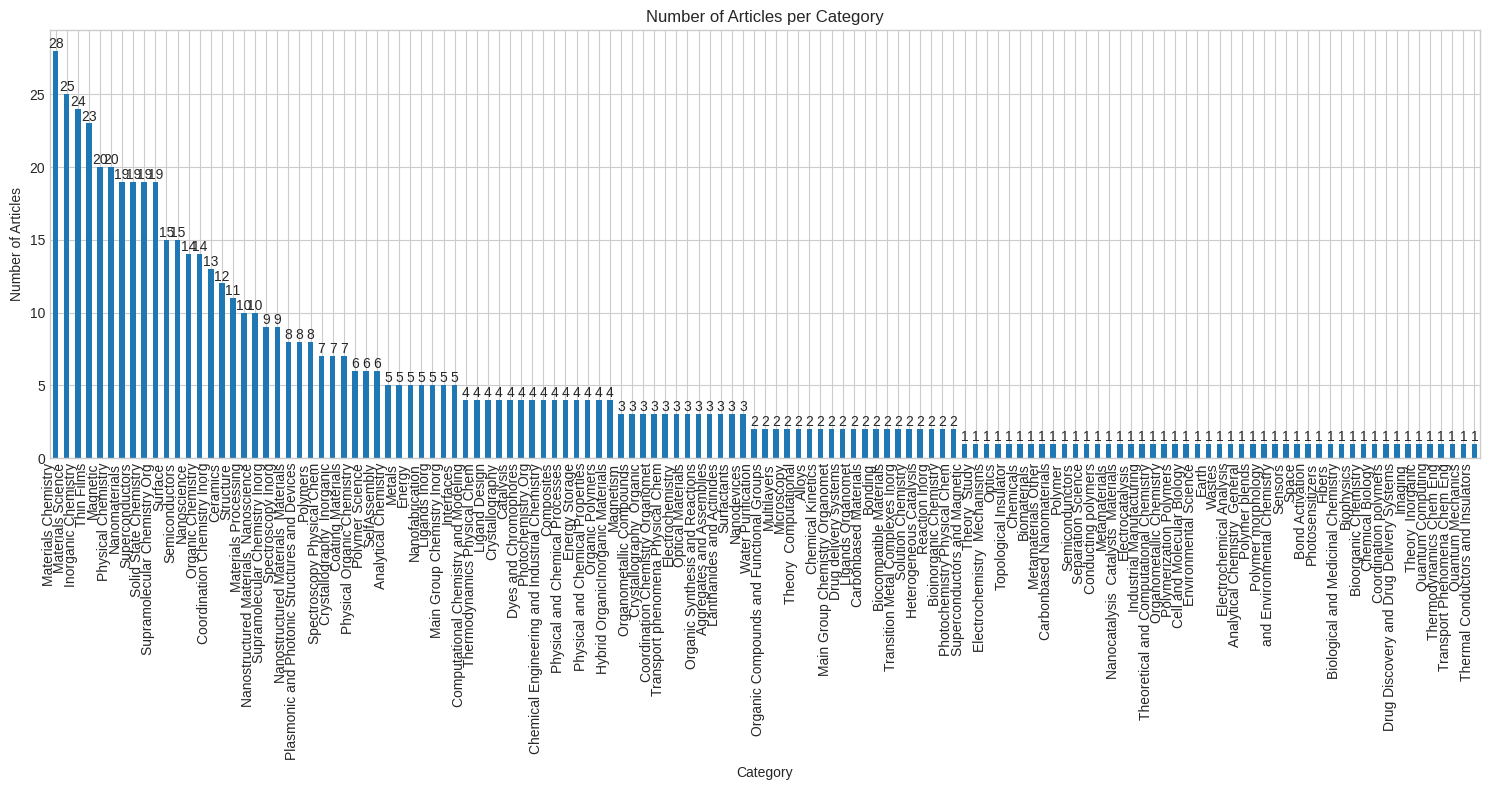

In [ ]:
# Function to clean and flatten category strings (copied from previous cell)
def clean_categories(categories_list):
    cleaned = []
    if isinstance(categories_list, str):
        try:
            categories_list = ast.literal_eval(categories_list)
        except (ValueError, SyntaxError):
            categories_list = [categories_list]

    if isinstance(categories_list, list):
        for category in categories_list:
            if isinstance(category, str):
                for part in category.split(','):
                    for sub_part in part.split(';'):
                         cleaned_category = re.sub(r'[^a-zA-Z0-9\s]', '', sub_part).strip()
                         if cleaned_category:
                             cleaned.append(cleaned_category)
    return cleaned

# Apply the cleaning function to the 'categories' column within this cell
data['cleaned_categories'] = data['categories'].apply(clean_categories)

# Flatten the list of lists and explicitly filter out 'N/A', 'Other', 'Others', and 'NA' (case-insensitive)
all_cleaned_categories = [
    category for sublist in data['cleaned_categories'] for category in sublist
    if category.lower() not in ['n/a', 'other', 'others', 'na']
]

# Count the occurrences of each filtered category
category_counts = Counter(all_cleaned_categories)

# Convert the counts to a pandas Series for easy plotting
category_counts_series = pd.Series(category_counts).sort_values(ascending=False)

# Plot a bar plot of the category counts
plt.figure(figsize=(15, 8))
ax = category_counts_series.plot(kind='bar')

plt.title('Number of Articles per Category')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()

# Add the exact number above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

**Observations:**

This histogram reveals the most frequent categories in this dataset, as seen previously in the frequency of categories: materials chemistry/science, inorganic chemsitry and thin films.

Top 20 categories selected for the heatmap: ['Ceramics', 'Coordination Chemistry (Inorg.)', 'Inorganic Chemistry', 'Magnetic', 'Materials Chemistry', 'Materials Processing', 'Materials Science', 'Nanomaterials', 'Nanoscience', 'Nanostructured Materials - Nanoscience', 'Organic Chemistry', 'Physical Chemistry', 'Semiconductors', 'Solid State Chemistry', 'Structure', 'Superconductors', 'Supramolecular Chemistry (Inorg.)', 'Supramolecular Chemistry (Org.)', 'Surface', 'Thin Films']


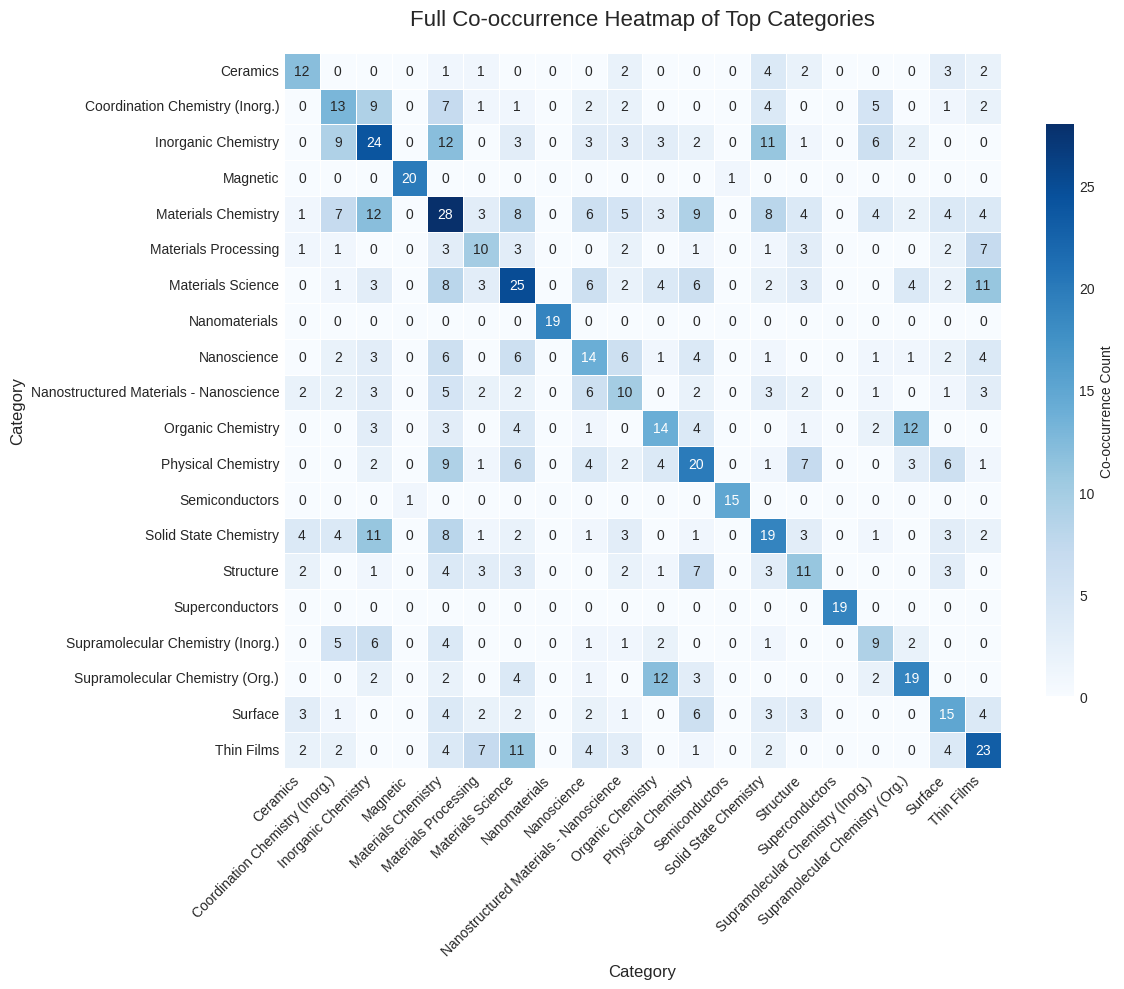

In [ ]:
data2 = pd.DataFrame(data['categories'])

# Function to split and clean category strings - Modified to split by comma and semicolon
def clean_categories(category_string):
    if isinstance(category_string, str):
        # Split by comma and then by semicolon, strip whitespace, handle potential empty strings
        categories = []
        for part in category_string.split(','):
            for sub_part in part.split(';'):
                cleaned_cat = sub_part.strip()
                # Convert to lowercase for case-insensitive filtering
                if cleaned_cat and cleaned_cat.lower() not in ['n/a', 'other', 'others', 'na']:
                    categories.append(cleaned_cat)
        return categories
    elif isinstance(category_string, list):
        return [cat.strip() for cat in category_string if isinstance(cat, str) and cat.strip().lower() not in ['n/a', 'other', 'others', 'na']]
    else:
        return []

# Apply the cleaning function
data2['cleaned_categories'] = data2['categories'].apply(clean_categories)

# --- 1. Select Top N Categories ---
# Calculate the frequency of each category
all_cats_list = [cat for sublist in data2['cleaned_categories'] for cat in sublist]
category_counts = Counter(all_cats_list)

# Define how many top categories you want to see
N = 20
top_categories = [cat for cat, count in category_counts.most_common(N)]
top_categories = sorted(top_categories) # Sort alphabetically for consistent order

print(f"Top {len(top_categories)} categories selected for the heatmap: {top_categories}")


# --- 2. Create Co-occurrence Matrix for Top Categories ---
# Initialize the DataFrame with dtype=float
co_occurrence_matrix = pd.DataFrame(0, index=top_categories, columns=top_categories, dtype=float)

# Populate the matrix
for categories_list in data2['cleaned_categories']:
    # Filter the list to only include top categories
    filtered_list = [cat for cat in categories_list if cat in top_categories]
    # Use a set to get unique categories for co-occurrence counting within a single entry
    for cat1 in set(filtered_list):
        for cat2 in set(filtered_list):
            if cat1 in co_occurrence_matrix.index and cat2 in co_occurrence_matrix.columns:
                 co_occurrence_matrix.loc[cat1, cat2] += 1

# --- 3. Plot the Heatmap (Full Matrix) ---
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(
    co_occurrence_matrix,
    annot=True,
    cmap='Blues',
    fmt='.0f',
    linewidths=.5,
    cbar_kws={"shrink": .8, "label": "Co-occurrence Count"}
)

# Improve plot aesthetics
plt.title('Full Co-occurrence Heatmap of Top Categories', fontsize=16, pad=20)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Observations:**

This heatmap reveals the predominant interdisciplinary fields in materials science and chemistry. Inorganic chemistry is strongly linked to materials chemistry and solid state chemistry. Materials chemistry is also linked to physical chemistry. Finally, materials science co-occurs significantly with thin films and materials chemistry. The analysis highlights clear interactions between fundamental chemistry and materials applications. Plus, Supramolecular Chemisry (Org.) is correlated to Organic Chemistry.

The diagonal indicates individual frequency, and off-diagonal values quantify interdisciplinary links.

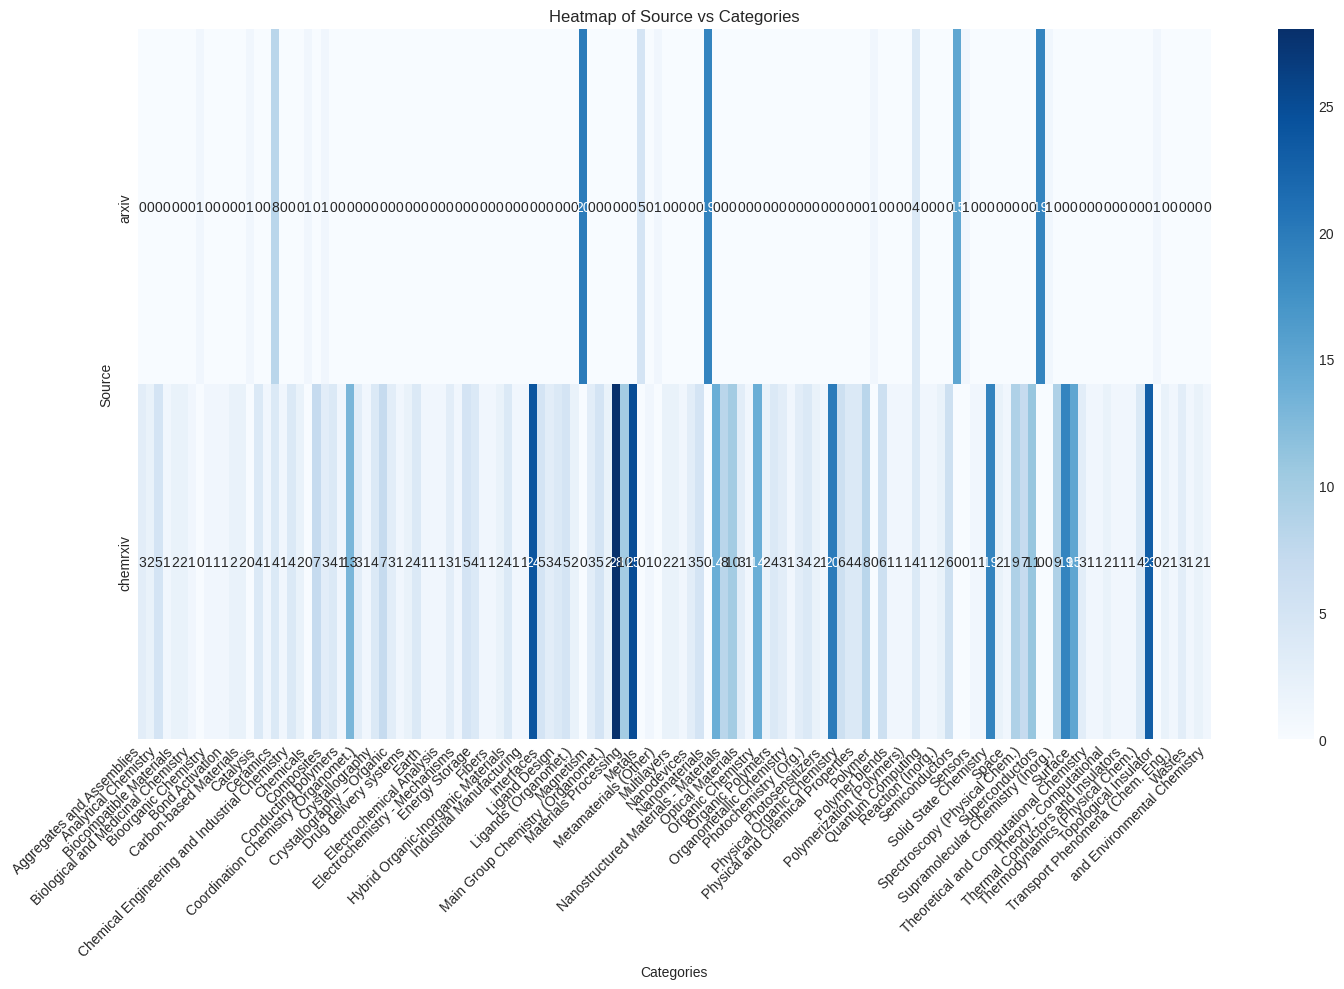

In [ ]:
# Create heatmap with the categories columns and source

# Apply the cleaning function and create a list of (source, category) pairs
source_category_pairs = []
for index, row in data.iterrows():
    source = row['source']
    cleaned_cats = clean_categories(row['categories'])
    for category in cleaned_cats:
        source_category_pairs.append({'source': source, 'category': category})

# Create a DataFrame from the pairs
source_category_df = pd.DataFrame(source_category_pairs)

# Create a crosstab of source and categories using the new DataFrame
if not source_category_df.empty:
    crosstab_data = pd.crosstab(source_category_df['source'], source_category_df['category'])

    plt.figure(figsize=(15, 10))
    sns.heatmap(crosstab_data, annot=True, fmt='d', cmap='Blues')
    plt.title('Heatmap of Source vs Categories')
    plt.xlabel('Categories')
    plt.ylabel('Source')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No valid category-source pairs found after cleaning.")

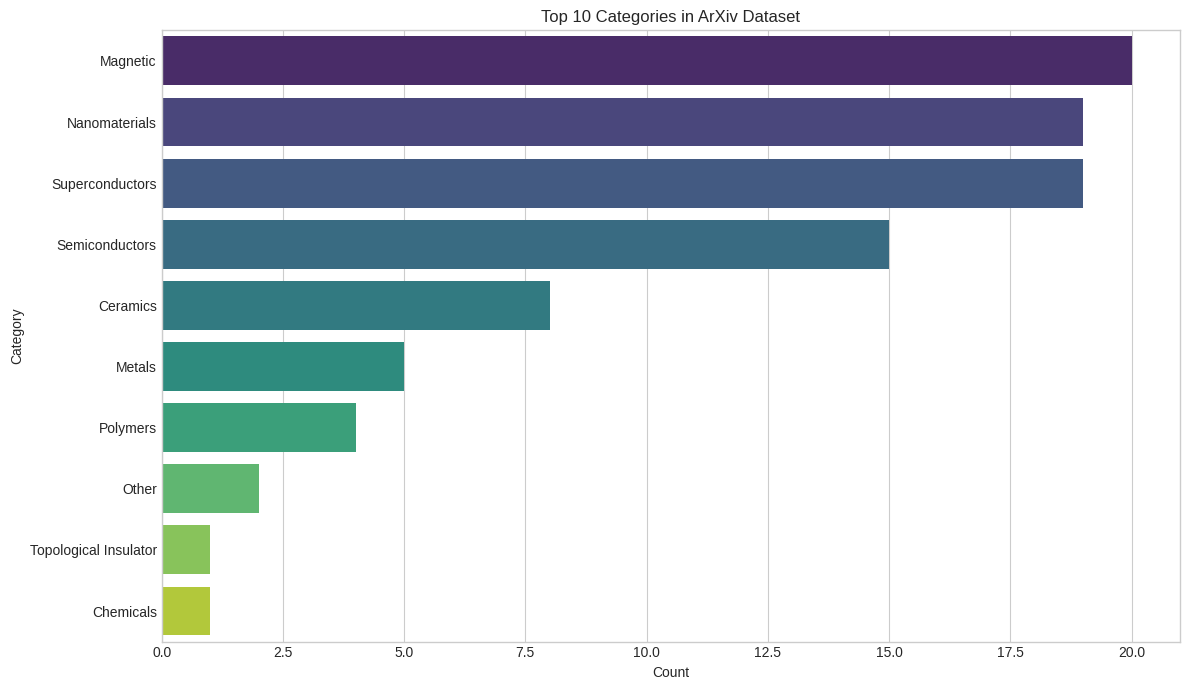

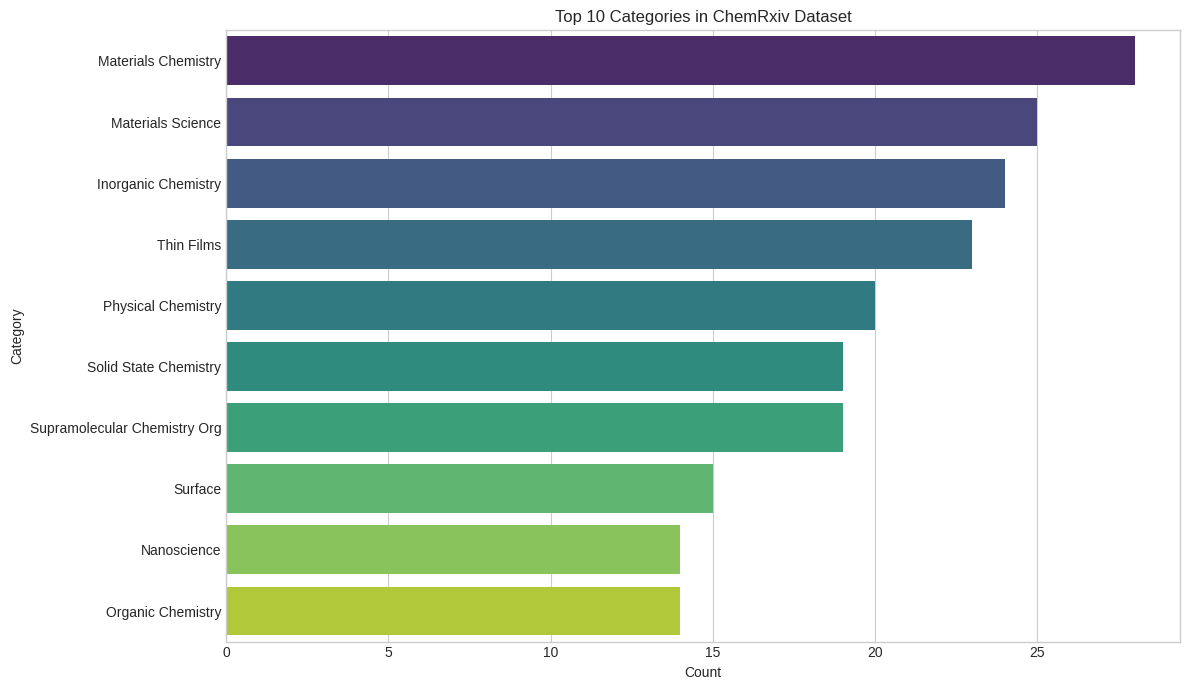

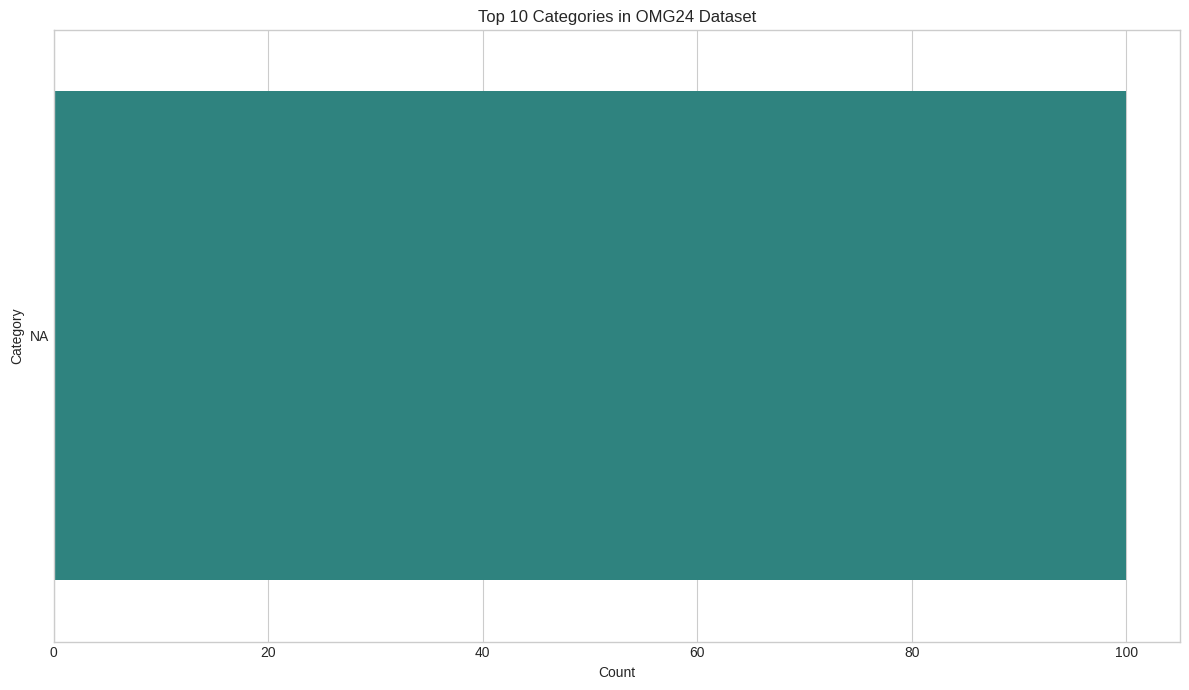

In [ ]:
# Function to clean and flatten category strings (more robust version)
def clean_categories_for_counting(categories_list):
    cleaned = []
    if isinstance(categories_list, str):
        try:
            categories_list = ast.literal_eval(categories_list)
        except (ValueError, SyntaxError):
            categories_list = [categories_list]

    if isinstance(categories_list, list):
        for category in categories_list:
            if isinstance(category, str):
                for part in category.split(','):
                    for sub_part in part.split(';'):
                         cleaned_category = re.sub(r'[^a-zA-Z0-9\s]', '', sub_part).strip()
                         if cleaned_category:
                             cleaned.append(cleaned_category)
    return cleaned


# Function to get the most common categories for a given source using the main data DataFrame
def get_top_categories(df, source_name, n=10):
    source_df = df[df['source'] == source_name].copy()

    # Apply the cleaning function to the 'categories' column for the specific source
    source_df['cleaned_categories_list'] = source_df['categories'].apply(clean_categories_for_counting)

    # Flatten the list of lists of cleaned categories
    all_categories = [cat for sublist in source_df['cleaned_categories_list'].dropna() for cat in sublist]

    # Count the frequency of each category
    category_counts = Counter(all_categories)

    # Return the most common categories
    return category_counts.most_common(n)

# Get top categories for each source
top_n = 10
if 'data' in globals():
    arxiv_top_categories = get_top_categories(data, 'arxiv', n=top_n)
    chemrxiv_top_categories = get_top_categories(data, 'chemrxiv', n=top_n)
    omg24_top_categories = get_top_categories(data, 'omg24', n=top_n)


    def plot_categories(category_freq, title):
        if not category_freq:
            print(f"No category data to plot for {title}")
            return
        categories, counts = zip(*category_freq)
        plt.figure(figsize=(12, 7))
        sns.barplot(x=list(counts), y=list(categories), palette='viridis')
        plt.title(title)
        plt.xlabel("Count")
        plt.ylabel("Category")
        plt.tight_layout()
        plt.show()

    # Create bar charts for each source
    plot_categories(arxiv_top_categories, f"Top {top_n} Categories in ArXiv Dataset")
    plot_categories(chemrxiv_top_categories, f"Top {top_n} Categories in ChemRxiv Dataset")
    plot_categories(omg24_top_categories, f"Top {top_n} Categories in OMG24 Dataset")
else:
    print("Error: 'data' DataFrame not found. Please run the data loading cells.")

### **Number of views**

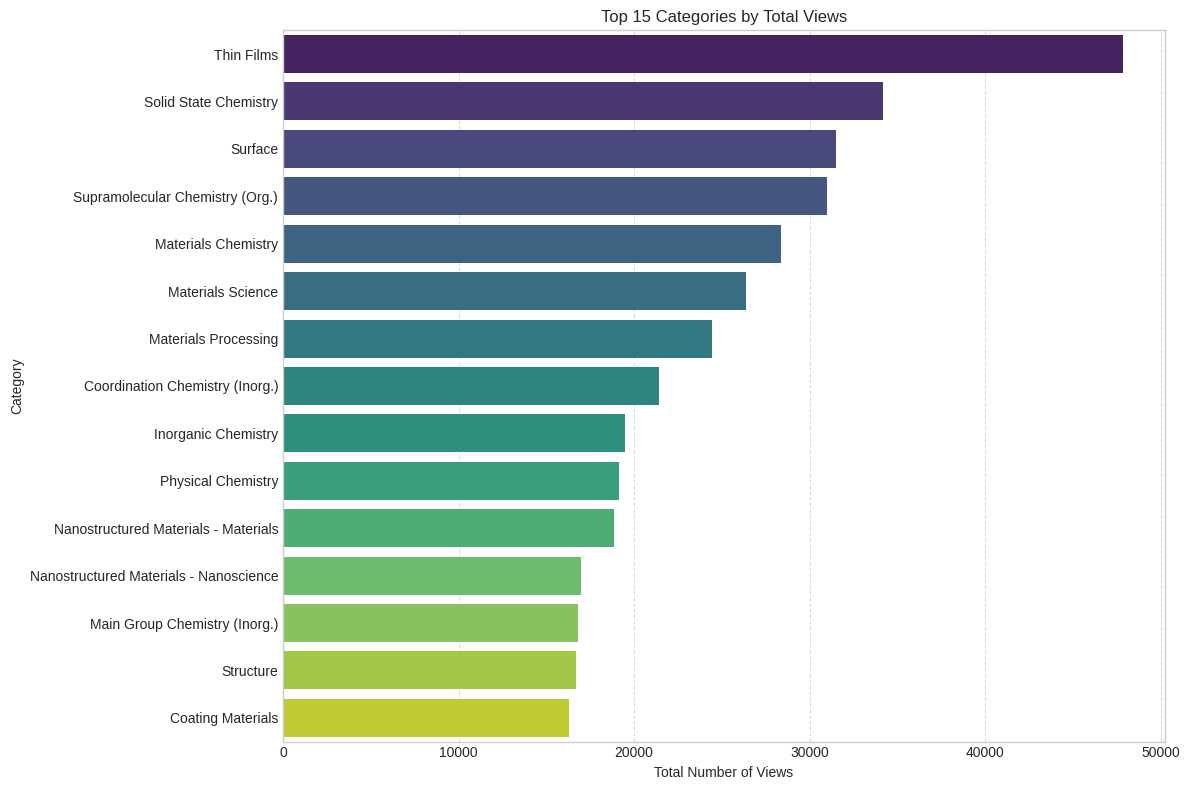

Top 15 Categories by Total Views:
                                  Category  Total_Views
26                              Thin Films      47820.0
18                   Solid State Chemistry      34147.0
37                                 Surface      31475.0
49         Supramolecular Chemistry (Org.)      30993.0
19                     Materials Chemistry      28375.0
23                       Materials Science      26372.0
51                    Materials Processing      24451.0
17         Coordination Chemistry (Inorg.)      21428.0
16                     Inorganic Chemistry      19479.0
41                      Physical Chemistry      19137.0
31    Nanostructured Materials - Materials      18844.0
43  Nanostructured Materials - Nanoscience      16980.0
76           Main Group Chemistry (Inorg.)      16779.0
56                               Structure      16703.0
96                       Coating Materials      16262.0


In [ ]:
# Drop rows where 'views_count' or 'categories' are NaN, as they are not useful for this analysis
data_cleaned = data.dropna(subset=['views_count', 'categories']).copy()

# Dictionary to store total views per category
category_views = defaultdict(float)

# Iterate through each row of the cleaned DataFrame
for index, row in data_cleaned.iterrows():
    views = row['views_count']
    # Only process if views is a valid number
    if pd.notna(views):
        categories = clean_categories(row['categories'])
        for category in categories:
            category_views[category] += views

# Convert the dictionary to a DataFrame for better manipulation and visualization
df_category_views = pd.DataFrame(category_views.items(), columns=['Category', 'Total_Views'])

# Sort categories by total views
df_category_views = df_category_views.sort_values(by='Total_Views', ascending=False)

# Select Top N categories for better readability (e.g., top 15)
top_n = 15
df_top_categories_views = df_category_views.head(top_n)

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(data=df_top_categories_views, x='Total_Views', y='Category', palette='viridis')
plt.title(f'Top {top_n} Categories by Total Views')
plt.xlabel('Total Number of Views')
plt.ylabel('Category')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Top {top_n} Categories by Total Views:")
print(df_top_categories_views)

## **Sources**

### **Number of views, reads and citations per source**

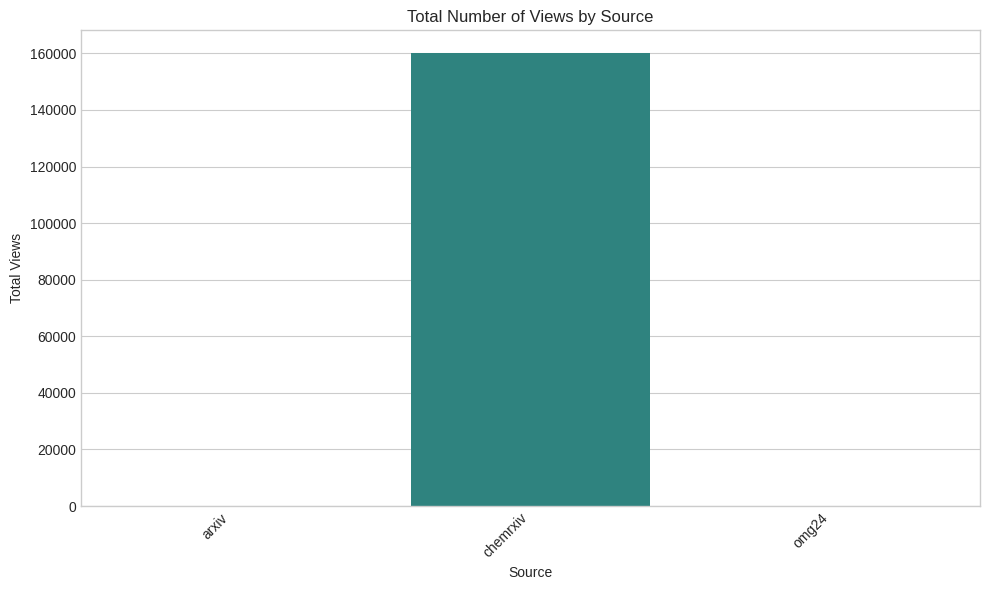

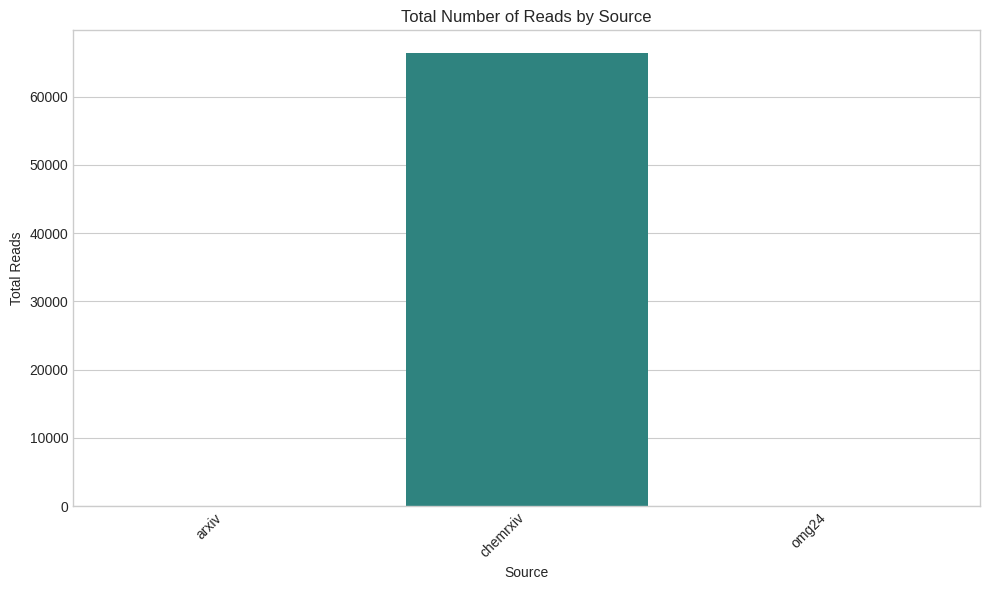

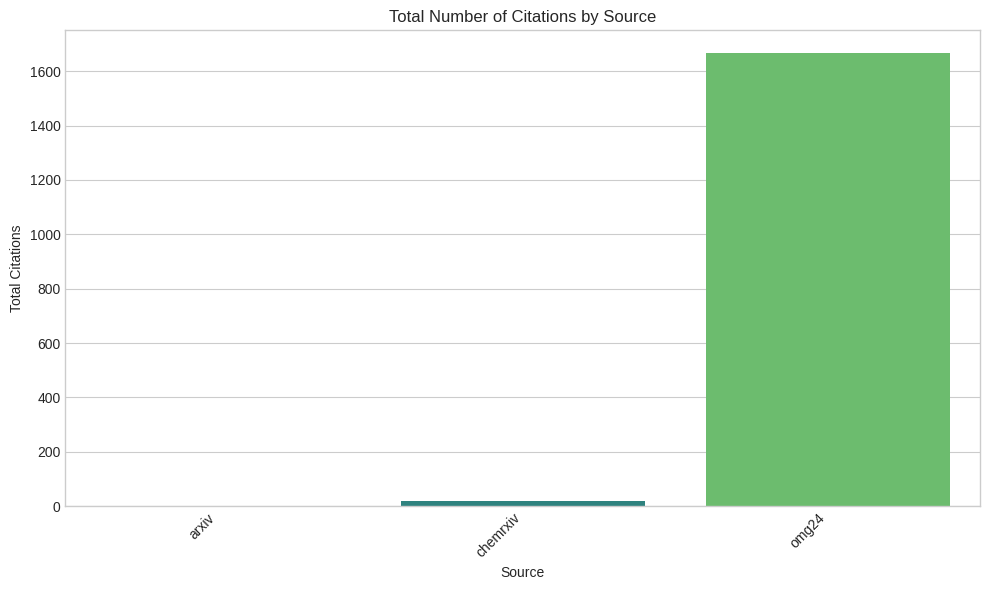

In [ ]:
# Create a copy and fill missing values with 0 for aggregation
df_aggregated_counts = data.copy()
df_aggregated_counts[['views_count', 'read_count', 'citation_count']] = df_aggregated_counts[['views_count', 'read_count', 'citation_count']].fillna(0)

# Group by source and calculate the total for each metric
total_counts_by_source = df_aggregated_counts.groupby('source')[['views_count', 'read_count', 'citation_count']].sum().reset_index()

# Melt the DataFrame to long format for easier plotting with seaborn
df_melted_counts = total_counts_by_source.melt(id_vars='source',
                                               value_vars=['views_count', 'read_count', 'citation_count'],
                                               var_name='Metric',
                                               value_name='Total_Count')

# Define custom titles and labels
metric_titles = {
    'views_count': 'Total Number of Views by Source',
    'read_count': 'Total Number of Reads by Source',
    'citation_count': 'Total Number of Citations by Source'
}

metric_ylabels = {
    'views_count': 'Total Views',
    'read_count': 'Total Reads',
    'citation_count': 'Total Citations'
}

# Create a separate plot for each metric
for metric in ['views_count', 'read_count', 'citation_count']:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_melted_counts[df_melted_counts['Metric'] == metric],
                x='source',
                y='Total_Count',
                palette='viridis')
    plt.title(metric_titles[metric])
    plt.xlabel('Source')
    plt.ylabel(metric_ylabels[metric])
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
# Create a pivot table.
pivot_table_by_source_sum = data.pivot_table(
    index='source',
    values=['views_count', 'read_count', 'citation_count'],
    aggfunc='sum'
)

print("\nPivot Table: Sum of Views, Reads, and Citations by Source:")
display(pivot_table_by_source_sum)


Pivot Table: Sum of Views, Reads, and Citations by Source:


,citation_count,read_count,views_count
source,,,
arxiv,0.0,0.0,0.0
chemrxiv,17.0,66393.0,160112.0
omg24,1667.0,0.0,0.0


### **Publication Trends Over time by source**

Data points per source after cleaning and filtering:
source
arxiv       100
chemrxiv    100
omg24       100
Name: count, dtype: int64
------------------------------

Unique sources in the aggregated data: ['arxiv', 'chemrxiv', 'omg24']

Head of publications_over_time DataFrame:
source          arxiv  chemrxiv  omg24
published_year                        
1996                1         0      0
1998                1         0      0
2000                2         0      0
2001                1         0      0
2002                3         0      0
------------------------------


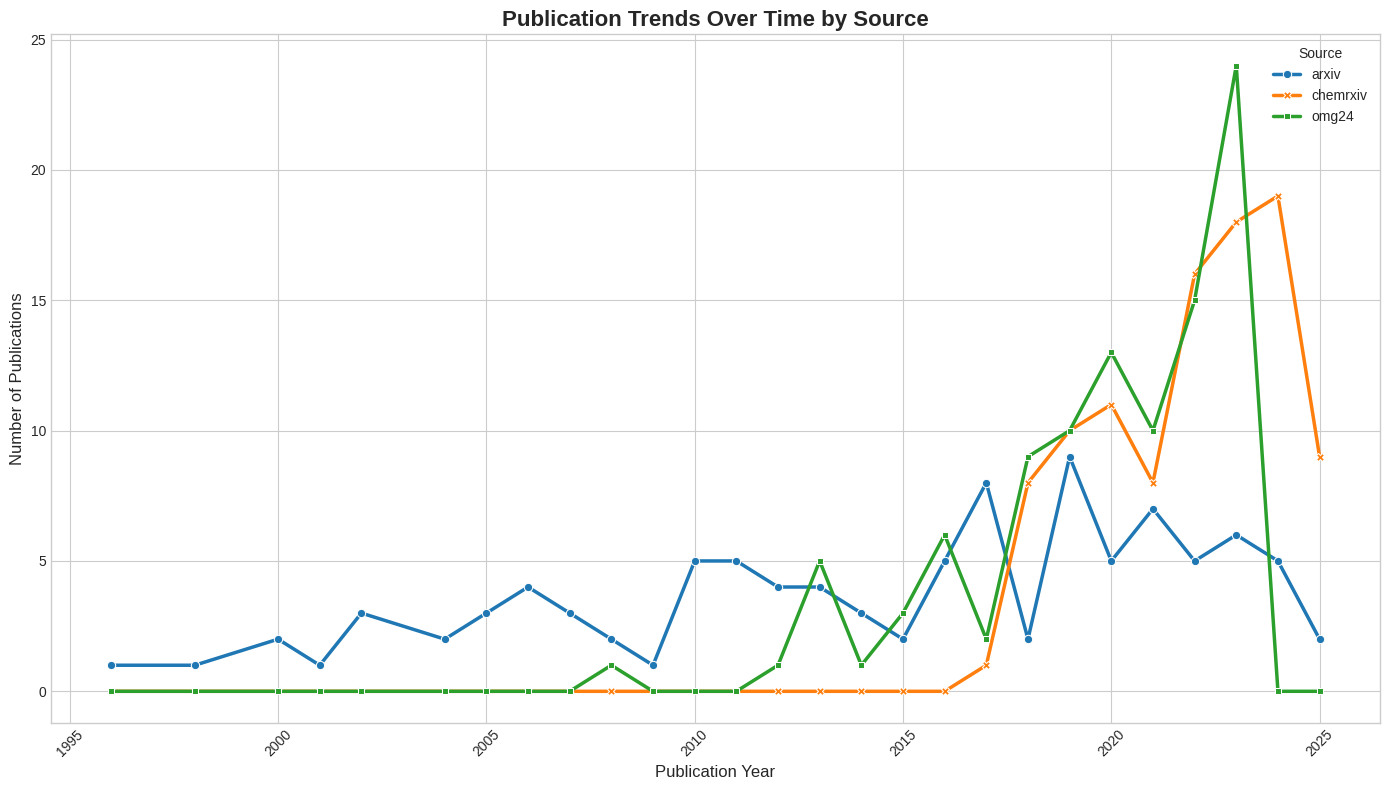

In [ ]:
try:
    data = pd.read_parquet("sample_for_evaluation.parquet")
except FileNotFoundError:
    print("Please make sure 'sample_for_evaluation.parquet' is in the same directory.")
    data = pd.DataFrame({
        'published_date': ['2020', '2021-01-01T00:00:00Z', '2022'],
        'source': ['arxiv', 'chemrxiv', 'omg24']
    })

data['published_year'] = data['published_date'].astype(str).str[:4]

# Convert the extracted year to a numeric type, coercing errors to NaN
data['published_year'] = pd.to_numeric(data['published_year'], errors='coerce')

# Drop rows where the year could not be parsed or is missing
data_cleaned = data.dropna(subset=['published_year']).copy()

# Convert the year column to integer type for clean plotting
data_cleaned['published_year'] = data_cleaned['published_year'].astype(int)

# Count the number of publications for each source for each year.
current_year = pd.Timestamp.now().year
valid_years_data = data_cleaned[(data_cleaned['published_year'] >= 1990) & (data_cleaned['published_year'] <= current_year + 5)].copy()

# Check if all sources are present after cleaning and filtering
print("Data points per source after cleaning and filtering:")
print(valid_years_data['source'].value_counts())
print("-" * 30)

# Group by year and source, then unstack to get sources as columns
publications_over_time = valid_years_data.groupby(['published_year', 'source']).size().unstack(fill_value=0)

# Print the sources and the head of the aggregated data to verify all three are present
print("\nUnique sources in the aggregated data:", publications_over_time.columns.tolist())
print("\nHead of publications_over_time DataFrame:")
print(publications_over_time.head())
print("-" * 30)

# Create a line plot showing the number of publications over time for each source
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))

if not publications_over_time.empty:
    sns.lineplot(data=publications_over_time, markers=True, dashes=False, linewidth=2.5)

    plt.title("Publication Trends Over Time by Source", fontsize=16, fontweight='bold')
    plt.xlabel("Publication Year", fontsize=12)
    plt.ylabel("Number of Publications", fontsize=12)
    plt.legend(title="Source", fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No valid publication data found to plot trends over time.")

### **Top words by source**

In [ ]:
# Download necessary NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab', quiet=True)


# Get English stop words
stop_words = set(stopwords.words('english'))

# Define a text preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    try:
        words = word_tokenize(text)
    except LookupError:
        nltk.download('punkt', quiet=True)
        words = word_tokenize(text)
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return " ".join(words)

# Filter data for each source
arxiv_df = data[data['source'] == 'arxiv'].copy()
chemrxiv_df = data[data['source'] == 'chemrxiv'].copy()
omg24_df = data[data['source'] == 'omg24'].copy()

# Combine and preprocess text for each source
arxiv_df['combined_text'] = arxiv_df['title'].fillna('') + ' ' + arxiv_df['abstract'].fillna('')
arxiv_df['cleaned_text'] = arxiv_df['combined_text'].apply(preprocess_text)

chemrxiv_df['combined_text'] = chemrxiv_df['title'].fillna('') + ' ' + chemrxiv_df['abstract'].fillna('')
chemrxiv_df['cleaned_text'] = chemrxiv_df['combined_text'].apply(preprocess_text)

omg24_df['combined_text'] = omg24_df['title'].fillna('') + ' ' + omg24_df['abstract'].fillna('')
omg24_df['cleaned_text'] = omg24_df['combined_text'].apply(preprocess_text)


# Perform word frequency analysis for each source
def get_word_frequencies(df, text_column='cleaned_text', n=30):
    if df.empty:
        return []
    all_words = ' '.join(df[text_column]).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

top_n = 30
arxiv_word_freq = get_word_frequencies(arxiv_df, n=top_n)
chemrxiv_word_freq = get_word_frequencies(chemrxiv_df, n=top_n)
omg24_word_freq = get_word_frequencies(omg24_df, n=top_n)

print("Top 30 words in ArXiv dataset:")
print(arxiv_word_freq)
print("\nTop 30 words in ChemRxiv dataset:")
print(chemrxiv_word_freq)
print("\nTop 30 words in OMG24 dataset:")
print(omg24_word_freq)

Top 30 words in ArXiv dataset:
[('magnetic', 122), ('quantum', 67), ('spin', 60), ('state', 47), ('properties', 46), ('structure', 46), ('phase', 46), ('measurements', 45), ('temperature', 45), ('field', 44), ('effect', 44), ('materials', 40), ('transition', 36), ('results', 35), ('using', 35), ('films', 35), ('scattering', 34), ('electronic', 33), ('layer', 33), ('surface', 33), ('states', 32), ('high', 31), ('crystal', 31), ('single', 31), ('model', 31), ('two', 30), ('observed', 29), ('study', 28), ('transport', 28), ('graphene', 27)]

Top 30 words in ChemRxiv dataset:
[('materials', 67), ('using', 46), ('surface', 46), ('properties', 42), ('high', 42), ('metal', 36), ('spectroscopy', 34), ('structure', 30), ('molecular', 29), ('two', 29), ('electron', 28), ('also', 28), ('study', 27), ('water', 27), ('organic', 27), ('reaction', 27), ('phase', 27), ('new', 26), ('films', 26), ('xray', 26), ('stability', 26), ('chemical', 26), ('applications', 25), ('synthesis', 25), ('complexes', 2

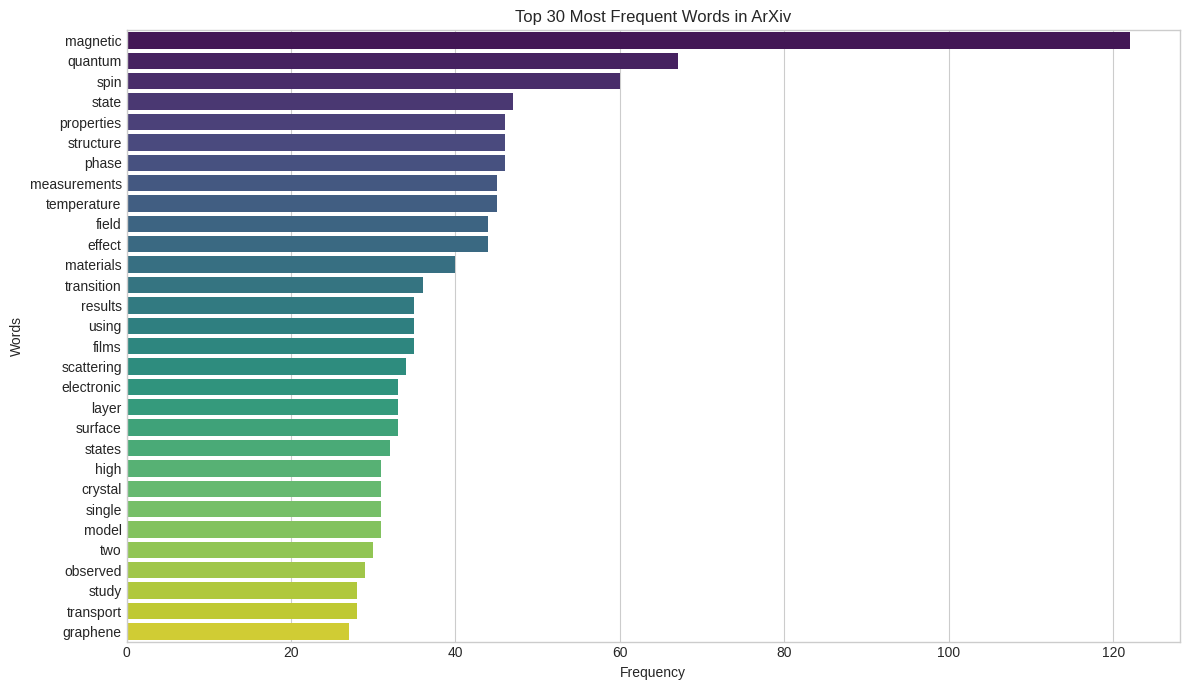

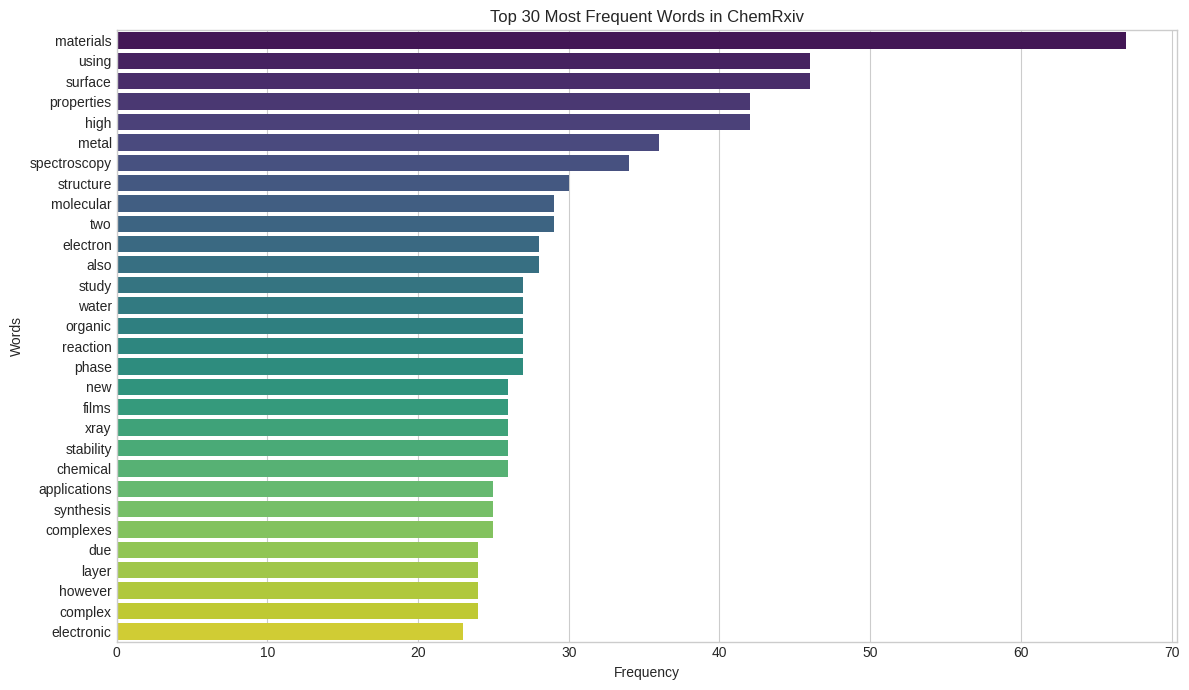

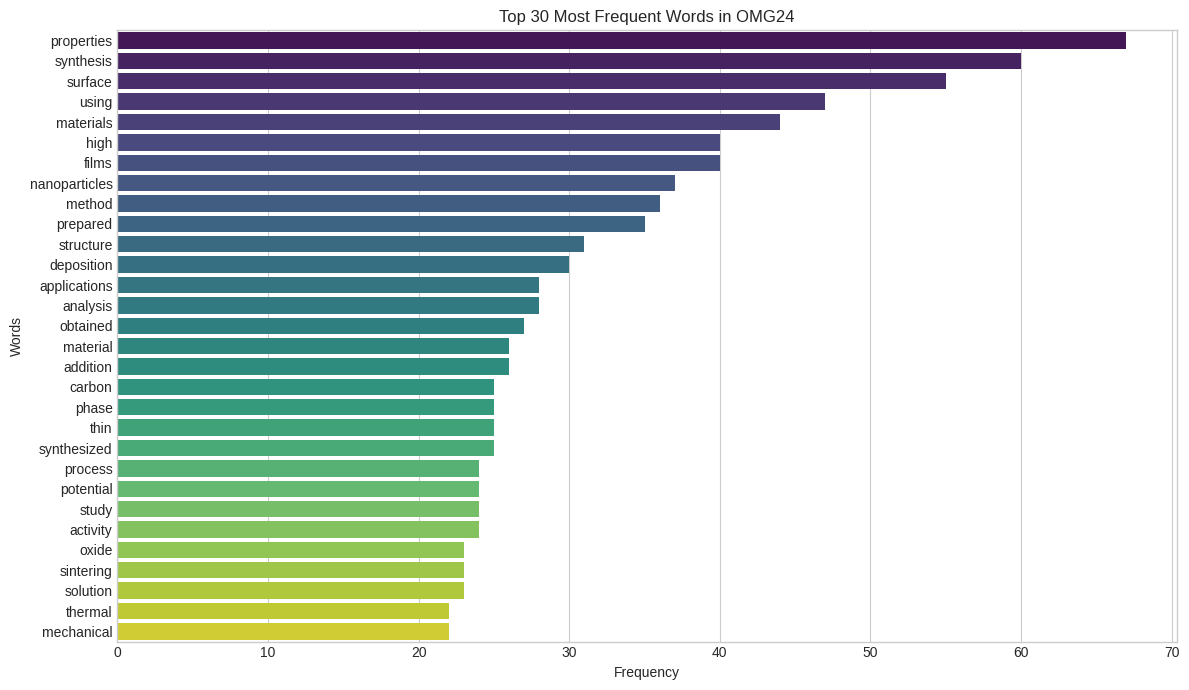

In [ ]:
# Function to create a bar chart of word frequencies
def plot_word_frequencies(word_freq, title):
    words, counts = zip(*word_freq)
    plt.figure(figsize=(12, 7))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.tight_layout()
    plt.show()

# Create bar charts for each source
plot_word_frequencies(arxiv_word_freq, "Top 30 Most Frequent Words in ArXiv")
plot_word_frequencies(chemrxiv_word_freq, "Top 30 Most Frequent Words in ChemRxiv")
plot_word_frequencies(omg24_word_freq, "Top 30 Most Frequent Words in OMG24")

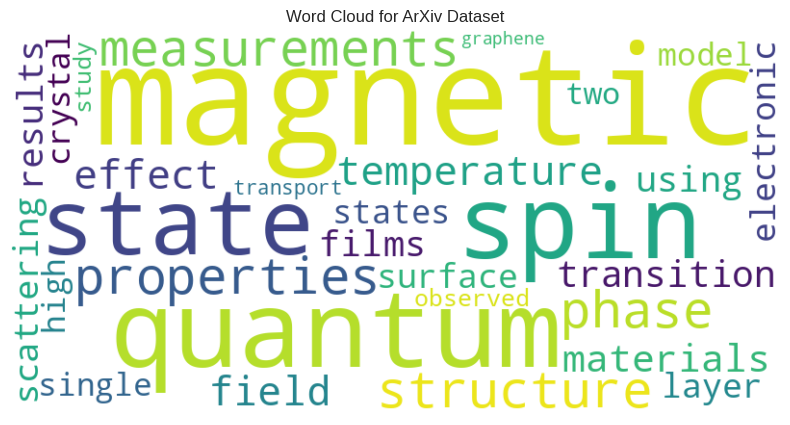

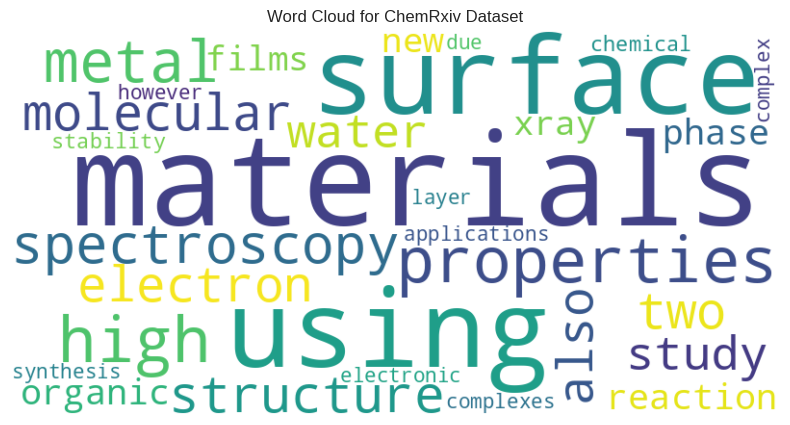

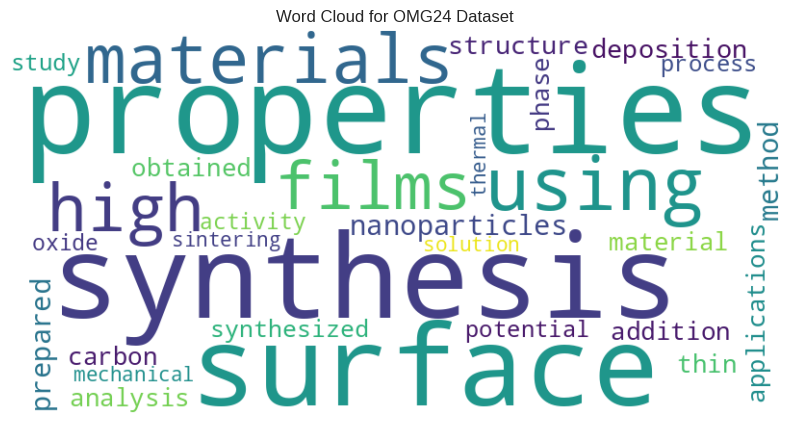

In [ ]:
# Function to generate and display a word cloud
def plot_word_cloud(word_freq, title):
    if not word_freq:
        print(f"No word frequency data available for '{title}'. Skipping word cloud generation.")
        return

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_freq))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate and display word clouds for each source
plot_word_cloud(arxiv_word_freq, "Word Cloud for ArXiv Dataset")
plot_word_cloud(chemrxiv_word_freq, "Word Cloud for ChemRxiv Dataset")
plot_word_cloud(omg24_word_freq, "Word Cloud for OMG24 Dataset")

### **Abstract lenght**

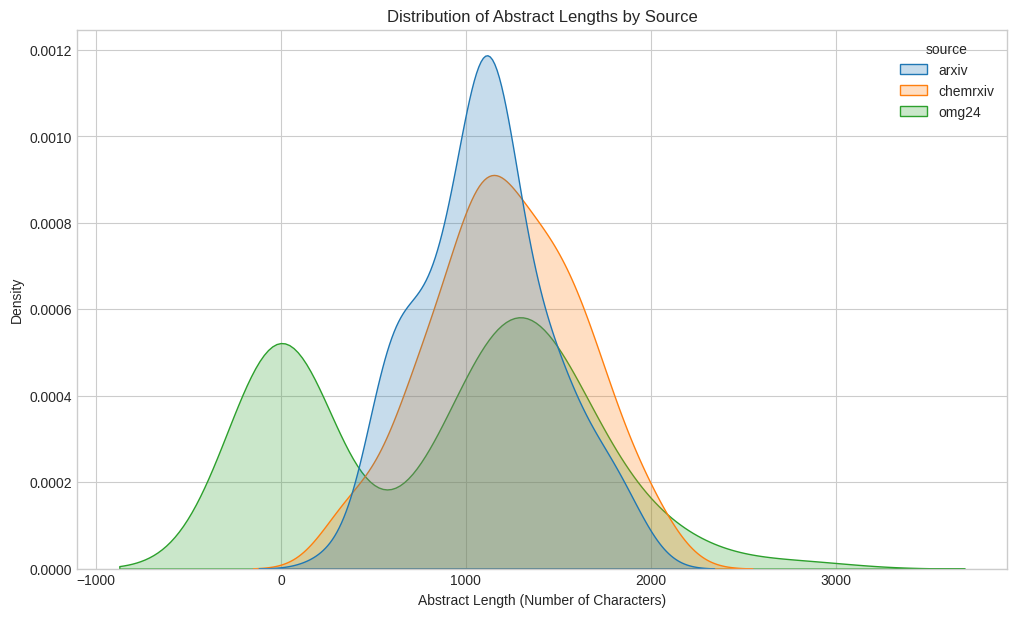

In [ ]:
# Combine the dataframes
if 'combined_df' not in locals():
    combined_df = pd.concat([arxiv_df.assign(source='arxiv'),
                             chemrxiv_df.assign(source='chemrxiv'),
                             omg24_df.assign(source='omg24')])

# Calculate the length of abstracts
combined_df['abstract_length'] = combined_df['abstract'].apply(lambda x: len(str(x)) if pd.notna(x) and x != 'N/A' else 0)

# Create a distribution plot (density plot) of abstract lengths by source
plt.figure(figsize=(12, 7))
sns.kdeplot(data=combined_df, x='abstract_length', hue='source', fill=True, common_norm=False)
plt.title("Distribution of Abstract Lengths by Source")
plt.xlabel("Abstract Length (Number of Characters)")
plt.ylabel("Density")
plt.show()

**Observations:**


This graph represents the distribution of abstract lengths (in number of characters) for three different sources: arXiv, chemrxiv, and omg24.

- The distribution of abstract lengths for arXiv is unimodal and relatively symmetrical, centred around 800-1000 characters, suggesting a standardised or preferred length for scientific publications submitted to this repository.

- The distribution for chemrxiv is also unimodal but wider and slightly asymmetrical (positive skewness), with a peak around 1200-1400 characters. This could indicate greater variability in abstract lengths for chemistry articles, perhaps due to specific disciplinary requirements or a greater diversity of topics requiring more or less detailed descriptions.

- In contrast, the distribution of omg24 is bimodal, with a pronounced first peak around 0-200 characters and a second broader and lower peak around 800-1000 characters. The presence of the first peak at very short lengths is notable and could indicate the presence of empty abstracts, very short summaries, or missing/atypical data in this source. The second peak partially overlaps with the distribution of arXiv, suggesting that some omg24 abstracts share similar length characteristics with those of arXiv. The nature of ‘omg24’ is unknown, but this bimodality raises questions about the typology of the documents or their completeness.